# Implementing, Training, and Evaluating a Neural Network with PyTorch for Handwritten Digit Classification 

__Notebook Author__: Hamed Qazanfari

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hamedmit/Neural-Networks-Deep-Dive/blob/main/NNs_with_torch.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/hamedmit/Neural-Networks-Deep-Dive/blob/main/NNs_with_torch.ipynb)

---

## Notebook Objectives

In this notebook, we will walk through the process of building, training, and evaluating a neural network model using PyTorch. The goal is to classify handwritten digits from the MNIST dataset, a common dataset in machine learning.
We will cover the following steps:

- Loading the MNIST dataset and preparing the data for training.
- Defining a fully connected neural network model and its architecture.
- Training the model using the Stochastic Gradient Descent (SGD) optimizer.
- Evaluating the model's performance on the test dataset.
- Visualizing the predictions and the model's confusion matrix.
- Experimenting with different optimizers to compare their performance.

By the end of this notebook, you will have a trained model for digit classification and an understanding of how to implement and monitor neural network training in PyTorch.

---

We begin by importing the essential libraries. Although it may look complex initially, we will walk through each step.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# plotting functions

from matplotlib import pyplot as plt
from tqdm import trange

def visualize(images, labels):
    """
    Visualize a batch of images.
    """
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def visualize_predictions(images, labels, predicted_labels):
    """
    Visualize a batch of images with their true and predicted labels.
    Titles are green if the prediction is correct, red if incorrect.
    """
    fig, axes = plt.subplots(8, 8, figsize=(11, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        color = 'green' if labels[i].item() == predicted_labels[i].item() else 'red'
        ax.set_title(f'True: {labels[i].item()}\nPred: {predicted_labels[i].item()}', color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_conf_mat(model, dataloader, device):
    """
    Plot the confusion matrix for a given model and dataloader.
    """
    # Initialize the confusion matrix
    total, correct = 0, 0
    conf_mat = torch.zeros((10, 10))
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total += pred.shape[0]
            pred = torch.argmax(pred, axis=1)
            correct += sum(pred == y).item()
            for j in range(pred.shape[0]):
                conf_mat[y[j], pred[j].item()] += 1
    # calculate the normalized confusion matrix
    norm_conf_mat = conf_mat / torch.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    # put number of each cell in plot
    for i in range(10):
        for j in range(10):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()

# Dataset

The dataset used for training is the [MNIST](https://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, which can be loaded via `torchvision`. For more datasets available through torchvision, you can refer to the list [here](https://pytorch.org/vision/0.8/datasets.html). Let's take a look at the parameters involved in this process.

*   `root` parameter specifies the directory from where the data will be loaded and stored.
*   `train` parameter decides whether we want to work with the training set or the test set.
*   `transform` parameter is used to apply transformations to the data. For now, we will only convert the data to a tensor for compatibility with PyTorch, but in upcoming notebooks, you will encounter more complex transformations.




In [4]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


print(f"Training data: {training_data}\n")
print(f"Test data: {test_data}")

Training data: Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test data: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


As you can see there are 60000 training samples in the training dataset and there are 10000 samples in the test dataset.

# Data Loaders

To simplify the data loading and processing, we will utilize the `DataLoader` from `torch.utils.data`. The DataLoader accepts a dataset and a `batch_size` parameter, enabling efficient iteration over the dataset. In this section, we will inspect one batch of data to observe the data shape:


In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Iterate over the data
for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64



As observed, the `x` data has the shape `[64, 1, 28, 28]`, indicating that we have a batch of `64` grayscale images, each with a single channel and a size of 28x28 pixels.
Similarly, the `y` data has the shape `[64]`, representing a batch of 64 labels. We will explore these labels in more detail in the next section.

# Visualization

In this section, we will visualize a single batch of data.

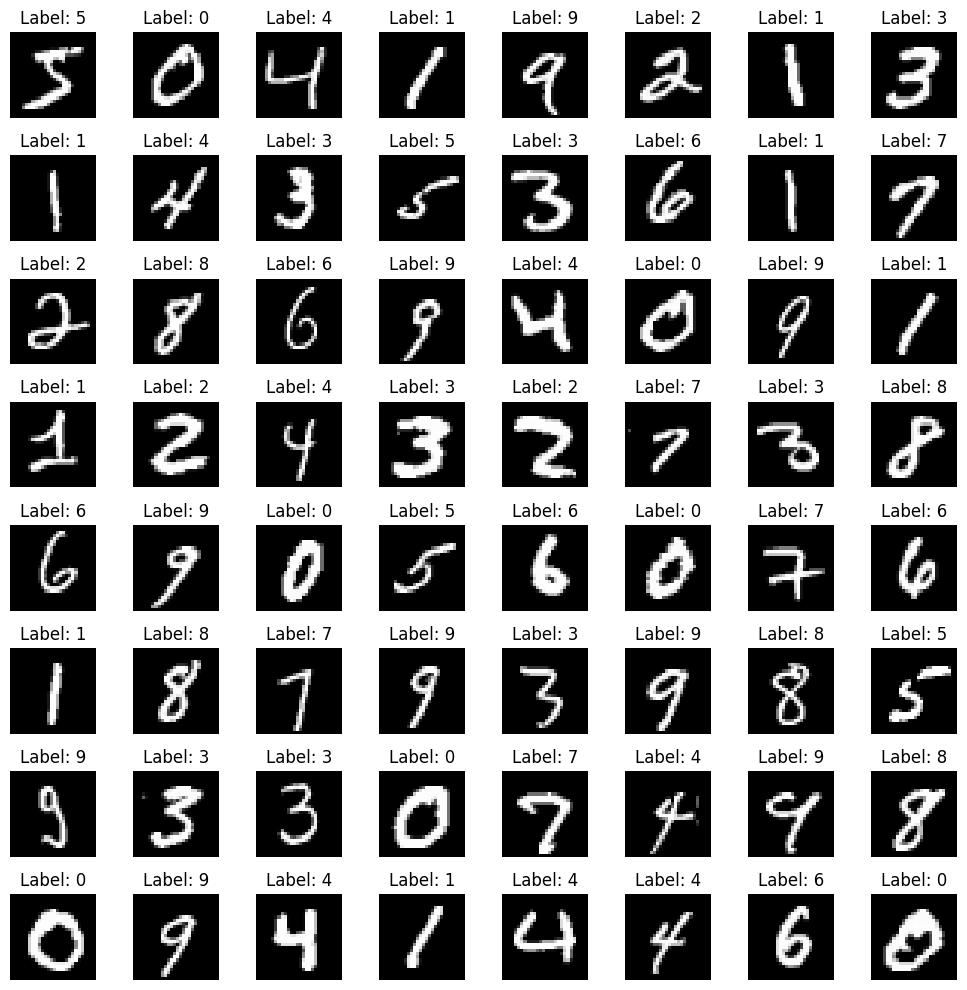

In [6]:
images, labels = next(iter(train_dataloader))

visualize(images, labels)

# Device

To enhance computation speed, we will transfer the operations to the GPU or MPS (for Apple Silicon) if available.

In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Model

Now, we define our neural network model. As each image batch has the shape `[64, 1, 28, 28]`, we need to **flatten** the inputs to feed them into the `Linear` layers. This is done using the `nn.Flatten()` module.

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Afterward, we proceed to initialize the model.

In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Loss Function

To classify the handwritten digits, we will use cross-entropy loss, which is suitable for classification tasks. You can explore more loss functions in PyTorch [here](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [10]:
loss_fn = nn.CrossEntropyLoss()

# Optimizer

Next, we need to configure an optimizer for model training. We will use stochastic gradient descent (SGD) by utilizing the `SGD` module from `torch.optim`. We pass the `model.parameters()` to the optimizer and set the learning rate `lr=1e-3`. In subsequent sessions, we will explore different optimizers in more detail. You can also learn more about PyTorch optimizers [here](https://pytorch.org/docs/stable/optim.html).

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Training

To train the model, we first define the number of epochs. For each epoch, we iterate over the entire training data and update the model parameters. For every batch, we first move the data to the same device as the model. Then, we predict the output, calculate the loss, perform the backward pass, update the parameters, and reset the gradients.

To track the training progress, we use `trange` from the `tqdm` library. It works similarly to the `range` function but also provides a progress bar (`pbar`) that displays helpful information.


In [12]:
# Number of epochs we wish to train the model
n_epochs = 30

for _ in (pbar := trange(n_epochs)):
    # Iterate over the data
    for x, y in train_dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the progress bar
        pbar.set_description(f'Loss = {loss.item():.3f}')

Loss = 0.181: 100%|██████████| 30/30 [08:29<00:00, 16.97s/it]


In future notebooks, we will explore more advanced techniques for monitoring training.

# Evaluation

Finally, we will evaluate the trained model on the test dataset. Using `torch.no_grad()`, we avoid calculating gradients, then we iterate over the test dataset and display the model’s accuracy.

In [13]:
# Store the number of correctly classified and total labels
correct, total = 0, 0

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the test data
    for x, y in test_dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Predict the output
        logits = model(x)
        # Get the predicted label
        pred = torch.argmax(logits, axis=1)
        # Update the number of correclty classified labels
        correct += sum(pred == y).item()
        # Update the number of total labels
        total += pred.shape[0]

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 90.67%


We will visualize a batch to compare the model's predictions with the true labels.

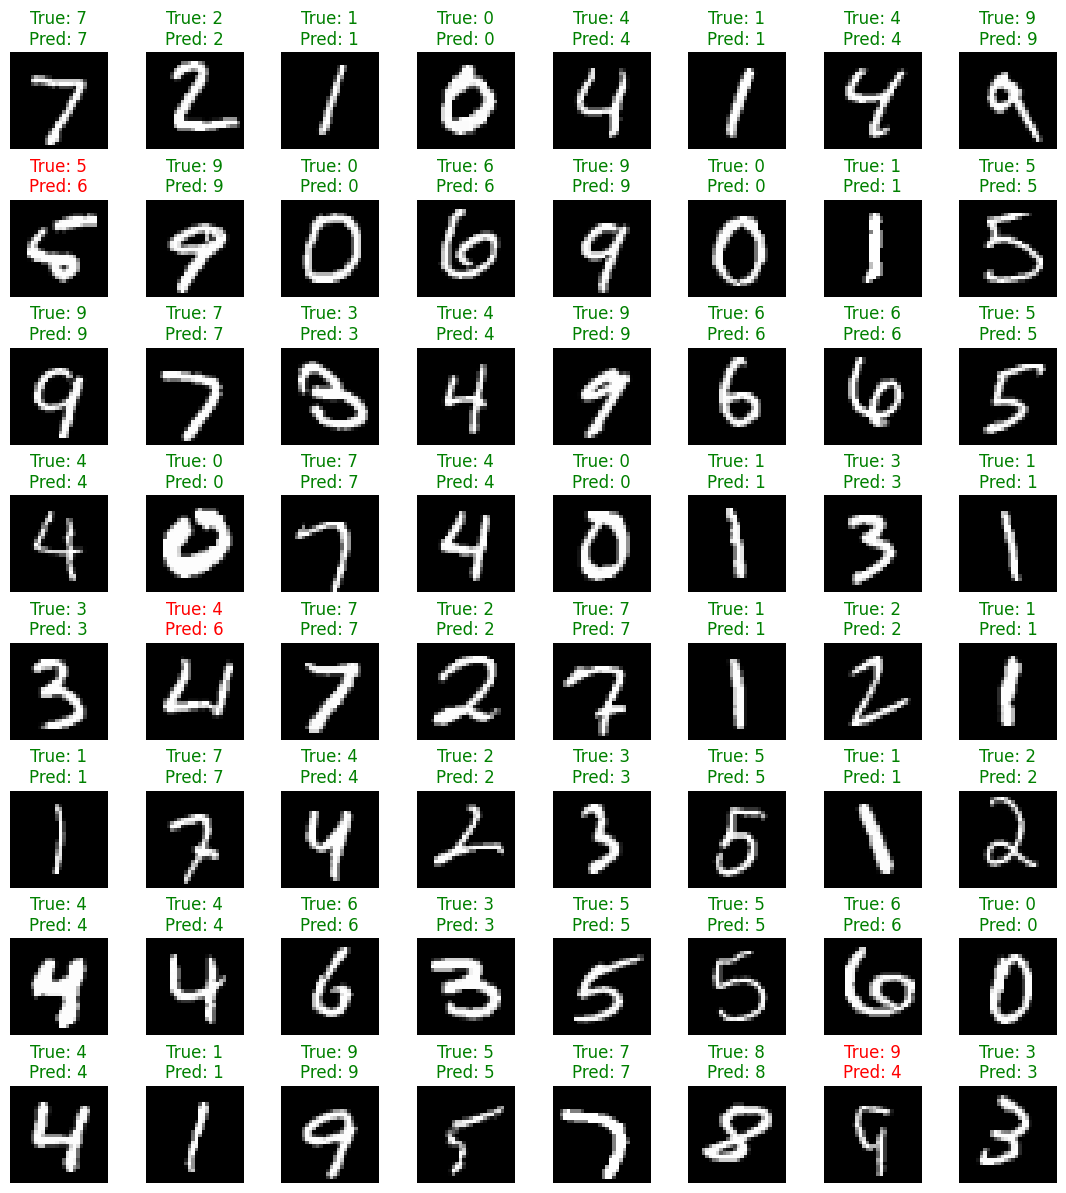

In [14]:
images, labels = next(iter(test_dataloader))
preds = torch.argmax(model(images.to(device)), axis=1).cpu()

visualize_predictions(images, labels, preds)

To gain further insight into the model’s performance, we will plot its confusion matrix.

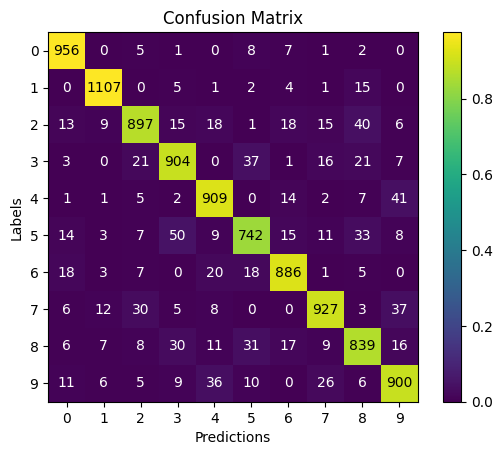

In [15]:
plot_conf_mat(model, test_dataloader, device)

# Experiments

In this section, we will examine various optimizers and their effects on training and convergence. You can use the widget below to train the model with different optimizers. Feel free to adjust the number of epochs or manually set the hyperparameters of each optimizer.

Dropdown(description='Optimizer:', layout=Layout(width='200px'), options=('SGD', 'AdaGrad', 'RMSProp', 'Adam')…


RMSProp


Loss = 0.011 | Accuracy = 99.62% : 100%|██████████| 10/10 [02:18<00:00, 13.90s/it]


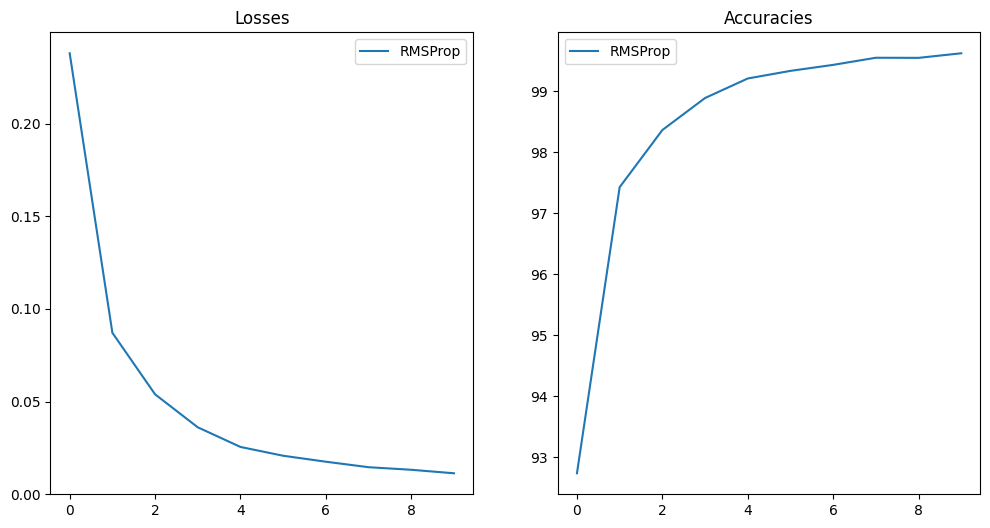

In [ ]:
# @markdown Optimizer Experimentation Widget

import ipywidgets as widgets
from IPython.display import display

train_dataloader = DataLoader(training_data, batch_size=128)

def train_model(model, optimizer, n_epochs=10):
    losses, accuracies = [], []
    for _ in (pbar := trange(n_epochs)):
        running_loss, acc = 0, 0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            pred = torch.argmax(pred, axis=1)
            acc += sum(pred == y).item()
        acc /= len(train_dataloader.dataset)
        acc *= 100
        running_loss /= len(train_dataloader)
        losses.append(running_loss)
        accuracies.append(acc)
        pbar.set_description(f'Loss = {running_loss:.3f} | Accuracy = {acc:.2f}% ')
    return losses, accuracies


def plot_losses_accuracies(results):
    fig, axes = plt.subplots(1, 2)
    for optimizer, res in results.items():
        if 'losses' not in res or 'accuracies' not in res:
            continue
        losses = res['losses']
        accuracies = res['accuracies']
        axes[0].plot(losses, label=optimizer)
        axes[1].plot(accuracies, label=optimizer)
    axes[0].set_title('Losses')
    axes[1].set_title('Accuracies')
    axes[0].legend()
    axes[1].legend()
    fig.set_size_inches(12, 6)
    plt.show()


# Create a list of values
options = ['SGD', 'AdaGrad', 'RMSProp', 'Adam']

# Create a dropdown widget with custom layout
dropdown = widgets.Dropdown(
    options=options,
    description='Optimizer:',
    layout={'width': '200px'},
    style={'description_width': 'initial'}

)

# Define a function to run based on selected value
def on_value_change(change):
    optimizer = change['new']
    global first_run, resuts
    model = NeuralNetwork().to(device)
    if results[optimizer] != {}:
        losses = results[optimizer]['losses']
        accuracies = results[optimizer]['accuracies']
        plot_losses_accuracies(results)
        return
    if optimizer == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=1e-3)
    elif optimizer == 'AdaGrad':
        opt = torch.optim.Adagrad(model.parameters(), lr=1e-3)
    elif optimizer == 'RMSProp':
        opt = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    elif optimizer == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    print(f'\n{optimizer}')
    losses, accuracies = train_model(model, opt)
    results[optimizer]['losses'] = losses
    results[optimizer]['accuracies'] = accuracies
    plot_losses_accuracies(results)



# Observe changes in the dropdown value
dropdown.observe(on_value_change, names='value')

results = {optimizer: dict() for optimizer in options}

# on_value_change({"new": 'SGD'})

# Display the widget
display(dropdown)


## conclusion
In conclusion, we have successfully implemented and trained a neural network for digit classification using the MNIST dataset. We demonstrated how to configure the training loop, set up an optimizer, and evaluate the model's performance.
Additionally, we visualized the model's predictions and compared different optimizers to understand their impact on training. This notebook serves as a foundation for further exploration into neural networks and deep learning techniques.